In [3]:
import sys
from pathlib import Path
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from Bio import SeqIO

from preprocessing.data_preprocessing import ProteinDataProcessor, create_dataset_with_emb


2025-12-15 23:04:20.526102: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 23:04:21.040176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 23:04:22.217823: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 23:04:22.217823: I tensorflow/core/util/port.cc:153] oneDNN custom operations ar

## Read training files and preprocessing

Read ../data//Train/train_sequences.fasta
Loaded Training sequence size: 82404
Read ../data//Train/train_terms.tsv
Loaded Training sequence size: 82404
Read ../data//Train/train_terms.tsv
Loaded Training sequence size: 82404
Removing sequences longer than 2375.0 (Top 1%)
Loaded Training sequence size: 82404
Removing sequences longer than 2375.0 (Top 1%)


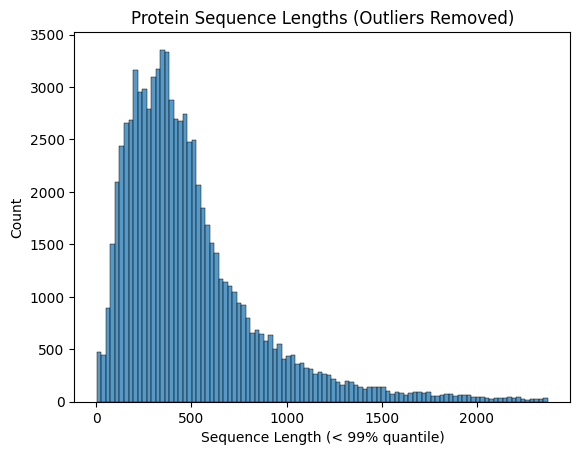

Original size: 82404, New size: 81578
--- Filtering terms with frequency <= 10 ---
Unique terms decrease from: 26125 to 7257
Removed 1501 proteins that became empty after filtering.
Final DataFrame shape: (80903, 2)
Training dataframe size: 80089
           ID                                           Sequence  \
0  A0A0C5B5G6                                   MRWQEMGYIFYPRKLR   
1      A0JNW5  MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...   
2      A0JP26  MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...   

                                                term  
0  [GO:0001649, GO:0033687, GO:0005615, GO:000563...  
1  [GO:0120013, GO:0034498, GO:0005769, GO:012000...  
2                                       [GO:0005515]  
Removed 1501 proteins that became empty after filtering.
Final DataFrame shape: (80903, 2)
Training dataframe size: 80089
           ID                                           Sequence  \
0  A0A0C5B5G6                                   MRWQEMGYIFYPRKLR   
1 

,ID,Sequence,term
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,"[GO:0001649, GO:0033687, GO:0005615, GO:000563..."
1,A0JNW5,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,"[GO:0120013, GO:0034498, GO:0005769, GO:012000..."
2,A0JP26,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...,[GO:0005515]
3,A0PK11,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,"[GO:0007605, GO:0005515]"
4,A1A4S6,MGLQPLEFSDCYLDSPWFRERIRAHEAELERTNKFIKELIKDGKNL...,"[GO:0005829, GO:0010008, GO:0005515, GO:000509..."


In [2]:
train_path = '../data/'
processor = ProteinDataProcessor(train_path, 'str')
train_df, info = processor.prepare_training_data()

display(train_df.head())

# Embedding T5

In [4]:
test_ids_path = '../data/embedding/prottrans/test_ids.npy'
test_ids = np.load(test_ids_path, allow_pickle=True)
train_ids = train_df["ID"].to_list()

train_emb, test_emb = create_dataset_with_emb(train_ids, test_ids, "prottrans")

print("Train size:", len(train_ids), "\nTest size:", len(test_ids))
print("Embedding shape:", train_emb.shape)

Train size: 80089 
Test size: 224309
Embedding shape: (80089, 1024)


# Prepare training

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

# Label
valid_label = set()
for subl in train_df.term:
  valid_label.update([label for label in subl])
valid_label = sorted(list(valid_label))

print("Number of valid class:", len(valid_label))

def create_label(valid_label: list, train_df: pd.DataFrame):
  mlb = MultiLabelBinarizer()
  label = mlb.fit_transform(train_df["term"])

  return label, mlb

y_train, mlb = create_label(valid_label, train_df)
print("Label shape:", y_train.shape)
y_train[:3]

Number of valid class: 7256
Label shape: (80089, 7256)
Label shape: (80089, 7256)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(3, 7256))

In [6]:
X_train = train_emb

print("Input shape:", X_train.shape)

Input shape: (80089, 1024)


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class ProteinClassifier(nn.Module):
    def __init__(self, input_dim=1024, num_classes=7256, dropout_rate=0.3):
        super(ProteinClassifier, self).__init__()

        self.network = nn.Sequential(
            # Layer 1: Nén nhẹ thông tin
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),      # Giúp hội tụ nhanh hơn
            nn.ReLU(),
            nn.Dropout(dropout_rate), # Chống học vẹt (Overfitting)

            # Layer 2: Trích xuất đặc trưng cấp cao
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Output Layer: Trả về Logits (chưa qua Sigmoid)
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [8]:
class GO_Dataset(Dataset):
    def __init__(self, embeddings, labels):
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
num_classes = y_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparam and loss func
model = ProteinClassifier(input_dim=1024, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

# Dataloader
train_dataset = GO_Dataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training
num_epochs = 20
print("Start Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs) # Outputs là logits

        # Calculate Loss
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Start Training...


KeyboardInterrupt: 

In [ ]:
def save_artifacts(model, model_path="../data/checkpoint/cafa_model.pth"):
    torch.save(model.state_dict(), model_path)
    print(f"Saved model weights to {model_path}")

save_artifacts(model)

import gc

# RAM free
del X_train, y_train, train_df
gc.collect()

# Inference

In [ ]:
from torch.utils.data import TensorDataset
target_terms = mlb.classes_

X_test = test_emb

test_tensor = torch.tensor(X_test, dtype=torch.float32)
test_dataset = TensorDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
import csv
from tqdm import tqdm


THRESHOLD = 0.01
output_file = 'submission.tsv'

device = torch.device("cuda")
num_classes = len(target_terms)
model = ProteinClassifier(input_dim=1024, num_classes=num_classes).to(device)
model.state_dict(torch.load("cafa_model.pth"))
model.to(device)
model.eval()


print(f"Writing to {output_file}...")

with open(output_file, 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\t')

    current_idx = 0

    with torch.no_grad():
        for inputs in tqdm(test_loader):
            # inputs từ TensorDataset là 1 tuple (data,), nên cần inputs[0]
            if isinstance(inputs, list) or isinstance(inputs, tuple):
                inputs = inputs[0]

            inputs = inputs.to(device)
            logits = model(inputs)
            probs = torch.sigmoid(logits) # (Batch_size, 7256)

            # Tìm các vị trí có xác suất > threshold
            # rows: chỉ số dòng (tương ứng protein nào trong batch)
            # cols: chỉ số cột (tương ứng GO term nào)
            rows, cols = torch.where(probs > THRESHOLD)

            # Lấy giá trị score tương ứng
            scores = probs[rows, cols]

            rows = rows.cpu().numpy()
            cols = cols.cpu().numpy()
            scores = scores.cpu().numpy()

            # Ánh xạ về ID thực và Term thực
            # Lấy ID thực tế từ mảng test_ids gốc
            # rows đang là index tương đối trong batch (0->63), cần cộng current_idx
            batch_real_ids = test_ids[current_idx + rows]
            batch_real_terms = target_terms[cols]

            rows_to_write = zip(batch_real_ids, batch_real_terms, scores)
            writer.writerows(rows_to_write)

            # Cập nhật vị trí index cho batch sau
            current_idx += inputs.size(0)

print("File submission created!.")